In [ ]:
# Version V1.1:
# Separate file for segmentation re-do. Multiple files can be re-segmented at the same time using modelNames. 
# Script loops through all datapaths and modelNames. 

## surface segmentation using ilastik, from h5 files

In [2]:
import ilastik.experimental.api
from ilastik.experimental.api import from_project_file
from xarray import DataArray
project_file = "/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/Death2/20241023_death_identification_RM_16nov24.ilp"
pipeline = from_project_file(project_file)

#### Load Libraries

In [5]:
# The environment to use here is: celltraj_env
#%%capture
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0,'/mnt/c/Users/copperma/OneDrive/Documents/cell/celltraj/celltraj')
import trajectory
import imageprep as imprep
import utilities
import features
import model
import h5py
import pickle
import os
import subprocess
import time
#import bootstrap
import umap
import pyemma.coordinates as coor
import scipy
import csaps
import skimage
from IPython.display import clear_output
import os
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
np.float=np.dtype(float)
np.int=int
import msmtools
import pandas
import itertools
import ray
import ilastik.experimental.api
from ilastik.experimental.api import from_project_file
import numpy
from xarray import DataArray

Solver suite is petsc


#### Load File Details

In [6]:
#%%capture

# This date is to make folders of analysis based off the date you do the analysis. 
date = '21nov24'
os.system(f'mkdir -p {date}')

# Make sure the model names are correct since these are what the file names have been called. If you want to rename
# the files, use script 'file_rename'
modelNames = [f'20241004_OS17lungInh2_RM'] 

datapaths=['/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM']

#### Loop through the segmented files

In [8]:
#%%capture
import imageprep as imprep
import itertools

modelLists = [None]*len(modelNames)
inds_imagingSet=[]
for idataset in range(len(modelNames)):
    modelLists[idataset]=imprep.list_images(f'{datapaths[idataset]}/{modelNames[idataset]}_xy*_roi*.h5')
    inds_dataset=[idataset]*len(modelLists[idataset])
    inds_imagingSet.append(inds_dataset)

inds_imagingSet=list(itertools.chain(*inds_imagingSet))

for ilist in range(len(modelLists)):
    print(f'movies: {modelLists[ilist]}')

#### Surface segmentation

In [36]:
#lp=1;hp=99;sigma=5;histp=None
def get_surf_fmasks_diff(img_ilastik,ilastik_model,cdict_ilp,cdict_surf,histp=None,sigma=5,thresh=0.,return_prediction=False):
    image = DataArray(img_ilastik, dims=("y", "x", "c"))
    prediction = ilastik_model.predict(image)
    prediction=prediction.to_numpy()
    for ichannel in range(prediction.shape[2]):
        pred=prediction[...,ichannel]
        if sigma is not None:
            pred=scipy.ndimage.gaussian_filter(pred,sigma=sigma)
        if histp is not None:
            plow, phigh = np.percentile(pred, (histp[0], histp[1]))
            pred=(pred-plow)/(phigh-plow)
        prediction[...,ichannel]=pred
    max_pred=np.argmax(prediction,axis=2)
    fmasks=np.zeros((img_ilastik.shape[0],img_ilastik.shape[1],len(cdict_surf))).astype(bool)
    fmasks[...,0]=((prediction[...,cdict_ilp['dead-cancer']]+prediction[...,cdict_ilp['live-cancer']]-prediction[...,cdict_ilp['lung']]-prediction[...,cdict_ilp['airway']])>0)
    fmasks[...,1]=((2*prediction[...,cdict_ilp['lung']]-prediction[...,cdict_ilp['live-cancer']]-prediction[...,cdict_ilp['dead-cancer']]-prediction[...,cdict_ilp['airway']])>0)
    fmasks[...,2]=((2*prediction[...,cdict_ilp['airway']]-prediction[...,cdict_ilp['live-cancer']]-prediction[...,cdict_ilp['dead-cancer']]-prediction[...,cdict_ilp['lung']])>0)
    fmasks[...,3]=np.logical_and((prediction[...,cdict_ilp['dead-cancer']]-prediction[...,cdict_ilp['live-cancer']])>0,np.logical_or(fmasks[...,1]==False,fmasks[...,2]==False))
    fmasks[prediction<thresh]=False
    if return_prediction:
        return prediction,fmasks
    else:
        return fmasks
    return fmasks

In [62]:
#lp=1;hp=99;sigma=5;histp=None
def get_surf_fmasks_relative(img_ilastik,ilastik_model,cdict_ilp,cdict_surf,histp=None,sigma=5,thresh=0.,return_prediction=False):
    image = DataArray(img_ilastik, dims=("y", "x", "c"))
    prediction = ilastik_model.predict(image)
    prediction=prediction.to_numpy()
    for ichannel in range(prediction.shape[2]):
        pred=prediction[...,ichannel]
        if sigma is not None:
            pred=scipy.ndimage.gaussian_filter(pred,sigma=sigma)
        if histp is not None:
            plow, phigh = np.percentile(pred, (histp[0], histp[1]))
            pred=(pred-plow)/(phigh-plow)
        prediction[...,ichannel]=pred
    max_pred=np.argmax(prediction,axis=2)
    predmax=np.max(prediction,axis=2)
    fmasks=np.zeros((img_ilastik.shape[0],img_ilastik.shape[1],len(cdict_surf))).astype(bool)
    fmasks[...,0]=np.isin(max_pred,[cdict_ilp['dead-cancer'],cdict_ilp['live-cancer']])#((prediction[...,cdict_ilp['dead-cancer']]+prediction[...,cdict_ilp['live-cancer']]-prediction[...,cdict_ilp['lung']]-prediction[...,cdict_ilp['airway']])>0)
    fmasks[...,1]=max_pred==cdict_ilp['lung'] #((prediction[...,cdict_ilp['lung']]-prediction[...,cdict_ilp['live-cancer']]-prediction[...,cdict_ilp['dead-cancer']]-prediction[...,cdict_ilp['airway']])>0)
    fmasks[...,2]=max_pred==cdict_ilp['airway'] #((prediction[...,cdict_ilp['airway']]-prediction[...,cdict_ilp['live-cancer']]-prediction[...,cdict_ilp['dead-cancer']]-prediction[...,cdict_ilp['lung']])>0)
    fmasks[...,3]=max_pred==cdict_ilp['dead-cancer'] #((prediction[...,cdict_ilp['dead-cancer']]-prediction[...,cdict_ilp['live-cancer']]-prediction[...,cdict_ilp['lung']]-prediction[...,cdict_ilp['airway']])>0)
    for imask in range(4):
        fmasks[predmax<thresh,imask]=False
    if return_prediction:
        return prediction,fmasks
    else:
        return fmasks

In [10]:
def get_surf_fmask_lung_cancer(img_ilastik,ilastik_model,cdict_ilp,cdict_surf,histp=None,sigma=5,thresh=0.2,return_prediction=False):
    image = DataArray(img_ilastik, dims=("y", "x", "c"))
    prediction = ilastik_model.predict(image)
    prediction=prediction.to_numpy()
    for ichannel in range(prediction.shape[2]):
        pred=prediction[...,ichannel]
        if sigma is not None:
            pred=scipy.ndimage.gaussian_filter(pred,sigma=sigma)
        if histp is not None:
            plow, phigh = np.percentile(pred, (histp[0], histp[1]))
            pred=(pred-plow)/(phigh-plow)
        prediction[...,ichannel]=pred
    max_pred=np.argmax(prediction,axis=2)
    fmasks=np.zeros((img_ilastik.shape[0],img_ilastik.shape[1],2)).astype(bool)
    fmasks[...,0]=(prediction[...,cdict_ilp['lung']]-prediction[...,cdict_ilp['airway']]>thresh)
    fmasks[...,1]=(prediction[...,cdict_ilp['live-cancer']]+prediction[...,cdict_ilp['dead-cancer']]-prediction[...,cdict_ilp['lung']]-prediction[...,cdict_ilp['airway']]>thresh)
    if return_prediction:
        return prediction,fmasks
    else:
        return fmasks
    return fmasks

In [11]:
cdict_ilp={'dead-cancer':0,'live-cancer':1,'lung':2,'airway':3}
cdict_surf={'cancer':0,'lung':1,'airway':2,'dead':3}
fmask_channels=['foreground','nuc','lung','cancer']

n_fmasks=2
ndimage=scipy.ndimage
nucl=25                                 #typical nucleus linear diameter pixels
micron_per_pixel=.33                    #lateral resolution (image pixel size)
micron_per_z=3.0                        #axial resolution between z-slices
nucl=25
rsmooth=nucl/4
thresh=0.2
zscale=micron_per_z/micron_per_pixel

ilastik_modelpath='/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/Death2/20241023_death_identification_RM_16nov24.ilp'
ilastik_model = from_project_file(ilastik_modelpath)

vizpath='/home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241121_surfseg'
pathexists = os.path.isdir(vizpath)     #create image folder if it doesn't exist already
if not pathexists:
    os.mkdir(vizpath)
    
visual=True
modelList_flat=list(itertools.chain(*modelLists))

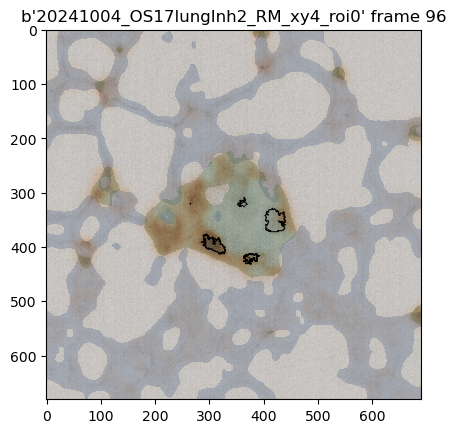

image 96 exists
    ...overwritten
mask 96 exists
    ...overwritten


In [17]:
# Actual surface segmentation
modelList_flat=list(itertools.chain(*modelLists))
modelSet=[None]*len(modelList_flat)
for i in range(len(modelList_flat)): 
    try:
        h5filename=modelList_flat[i]
        #moviename=modelNames[inds_imagingSet[i]] #messup no unique names
        modelSet[i]=trajectory.Trajectory(h5filename=h5filename)
        sctm=modelSet[i]
        moviename=sctm.figid #unique for each h5 file
        status=modelSet[i].load_from_h5('/cell_data_m0/')
        modelSet[i].get_image_shape()                             #some missing info, add in to metadata in future
        nuc_msk_channel=np.where(sctm.mask_channels==np.array(['nuc']).astype('S32'))[0][0]
        cyto_msk_channel=np.where(sctm.mask_channels==np.array(['cyto']).astype('S32'))[0][0]
        nuc_img_channel=np.where(sctm.channels==np.array(['DAPI']).astype('S32'))[0][0]
        rep_img_channel=np.where(sctm.channels==np.array(['YFP']).astype('S32'))[0][0]
        bf_img_channel=np.where(sctm.channels==np.array(['BF']).astype('S32'))[0][0]
        erk_img_channel=np.where(sctm.channels==np.array(['YFP']).astype('S32'))[0][0]
        akt_img_channel=np.where(sctm.channels==np.array(['TRITC']).astype('S32'))[0][0]
        fra1_img_channel=np.where(sctm.channels==np.array(['CFP']).astype('S32'))[0][0]
        mskchannel=sctm.mskchannel
        nt_roi=sctm.nt;nx_roi=sctm.nx;ny_roi=sctm.ny;nz_roi=sctm.nz
        sctm.ilastik_modelpath=ilastik_modelpath
        sctm.fmask_channels=fmask_channels
        sctm.save_to_h5('/metadata/',['ilastik_modelpath','fmask_channels'],overwrite=True)
        print(f'loaded {sctm.h5filename} with {sctm.mask_channels} mask channels, {sctm.channels} image channels, cell index on {mskchannel}') 
        nuc_channel=nuc_img_channel
        rep_channel=erk_img_channel
        bf_channel=bf_img_channel
        for iS in range(0,nt_roi):
            if visual:
                plt.figure(1)
                plt.clf();
            img=sctm.get_image_data(iS)
            msk=sctm.get_mask_data(iS)
            #fmsk_fore=sctm.get_fmask_data(iS,channel=0)
            #fmsk_nuc=sctm.get_fmask_data(iS,channel=1)
            fmsk_fore=msk[...,0]>0
            fmsk_nuc=msk[...,nuc_msk_channel]>0
            im3d_nuc=rescale_to_int(imprep.znorm(img[...,nuc_channel]))
            im3d_rep=rescale_to_int(imprep.znorm(img[...,rep_channel]))
            im3d_bf=imprep.znorm(img[...,bf_channel])
            im3d_bf=skimage.filters.difference_of_gaussians(im3d_bf,.5,1.5)
            im3d_bf=rescale_to_int(im3d_bf)
            cellpose_img=np.zeros((nz_roi,3,nx_roi,ny_roi)).astype(np.uint16)
            cellpose_img[:,0,:,:]=im3d_bf #add in nuc so not hollow
            cellpose_img[:,1,:,:]=im3d_rep
            cellpose_img[:,2,:,:]=im3d_nuc
            fmasks=np.zeros((nz_roi,nx_roi,ny_roi,n_fmasks)).astype(bool)
            predictions=np.zeros((nz_roi,nx_roi,ny_roi,len(cdict_ilp)))
            for iz in range(nz_roi):
                print(f'getting ilastik prediction frame {iS} slice {iz} of {nz_roi}')
                img_ilastik=cellpose_img[iz,...]
                img_ilastik=np.swapaxes(img_ilastik,0,2);img_ilastik=np.swapaxes(img_ilastik,0,1)
                predictions[iz,...],fmasks[iz,...]=get_surf_fmask_lung_cancer(img_ilastik,ilastik_model,cdict_ilp,cdict_surf,sigma=rsmooth,thresh=thresh,return_prediction=True)
            if visual:
                clear_output(wait=True)
                if sctm.ndim==3:
                    iz=np.argmax(np.sum(msk[...,0],axis=(1,2)))
                    #fmask_viz=np.max(fmasks,axis=0)
                    #img_viz=np.max(img,axis=0)
                    fmask_viz=fmasks[iz,...]
                    img_viz=img[iz,...]
                    msk_viz=msk[iz,...]
                    pred_viz=predictions[iz,...,0]
                else:
                    fmask_viz=fmasks
                    img_viz=img
                    msk_viz=msk
                plt.imshow(img_viz[...,erk_img_channel],cmap=plt.cm.gray_r)
                plt.contour(msk_viz[...,0],levels=np.unique(msk_viz[...,0]),colors='black',linewidths=.5)
                plt.imshow(np.ma.masked_where(np.logical_not(fmask_viz[...,0]),np.ones_like(fmask_viz[...,0])),alpha=.3,cmap=plt.cm.Blues,clim=(0,1))
                plt.imshow(np.ma.masked_where(np.logical_not(fmask_viz[...,1]),np.ones_like(fmask_viz[...,1])),alpha=.3,cmap=plt.cm.Greens,clim=(0,1))
                plt.imshow(pred_viz,alpha=.3,cmap=plt.cm.Oranges);
                plt.title(f'{moviename} frame {iS}')
                plt.savefig(f'{vizpath}/segcheck_{moviename}_f{iS}.png')
                plt.show()
            #predictions=(predictions*(2**16-1)).astype(int)
            #img=np.concatenate((img,predictions),axis=3)
            #img=np.concatenate((img[...,0:len(sctm.channels)],predictions[...,0][...,np.newaxis]),axis=3)
            fmsks=np.concatenate((fmsk_fore[...,np.newaxis],fmsk_nuc[...,np.newaxis],fmasks),axis=3)
            imprep.save_frame_h5(sctm.h5filename,iS,img=img,msks=msk,fmsk=fmsks,overwrite=True,timestamp=None)
    except Exception as e:
        print(e)
        pass

### featurize and track, including MVE boundary features

In [73]:
#@ray.remote(num_cpus=4)
def get_cellfeatures_distributed(h5filename):
    output_message=f'featurizing {h5filename}...'
    try:
        sctm=trajectory.Trajectory(h5filename=h5filename)
        sctm.get_image_shape()
        print(f'{sctm.nmaskchannels}')
        cyto_msk_channel=np.where(sctm.mask_channels==np.array(['cyto']).astype('S32'))[0][0]
        nuc_img_channel=np.where(sctm.channels==np.array(['DAPI']).astype('S32'))[0][0]
        rep_img_channel=np.where(sctm.channels==np.array(['YFP']).astype('S32'))[0][0]
        bf_img_channel=np.where(sctm.channels==np.array(['BF']).astype('S32'))[0][0]
        erk_img_channel=np.where(sctm.channels==np.array(['YFP']).astype('S32'))[0][0]
        akt_img_channel=np.where(sctm.channels==np.array(['TRITC']).astype('S32'))[0][0]
        fra1_img_channel=np.where(sctm.channels==np.array(['CFP']).astype('S32'))[0][0]
        foreground_fmskchannel=np.where(sctm.fmask_channels==np.array(['foreground']).astype('S32'))[0][0]
        nuc_fmskchannel=np.where(sctm.fmask_channels==np.array(['nuc']).astype('S32'))[0][0]
        mskchannel=cyto_msk_channel; sctm.mskchannel=mskchannel
        #sctm.load_from_h5('/cell_data_m{sctm.mskchannel}/')
        #output_message=f'{output_message} loaded cell data...'
        sctm.get_frames()
        sctm.get_cell_index(verbose=True,save_h5=True,overwrite=True)
        ntrans=[1,1,1]
        maxt=[0.,0.,0.]
        tf_matrix_set=sctm.get_stack_trans(mskchannel=sctm.mskchannel,ntrans=ntrans,maxt=maxt,dist_function=utilities.get_pairwise_distance_sum,save_h5=True,overwrite=True,do_global=False) #,contact_transform=True,r0=100.,d0=100.,n=6,m=12)
        clear_output(wait=True)
        x=sctm.get_cell_positions(mskchannel=sctm.mskchannel,save_h5=True,overwrite=True)
        clear_output(wait=True)
        tf_matrix_set_pad,pad_dims=imprep.get_registration_expansions(sctm.tf_matrix_set,sctm.nz,sctm.nx,sctm.ny)
        sctm.pad_dims=np.array(pad_dims)
        sctm.save_to_h5(f'/cell_data_m{mskchannel}/',['pad_dims'])
        clear_output(wait=True)
        ot_costs,linSet=sctm.get_lineage_min_otcost(distcut=0.5*sctm.cellpose_diam,return_cost=True,ot_cost_cut=np.inf,border_resolution=1.33,visual=False,save_h5=True,overwrite=True)
        output_message=f'{output_message} tracked...'
        clear_output(wait=True)
        #Bright field features with cyto masks
        Xf,feature_list=sctm.get_cell_features((features.featZernike,features.featHaralick,features.featBoundary),indcells=None,imgchannel=bf_img_channel,mskchannel=cyto_msk_channel,return_feature_list=True,save_h5=True,overwrite=True)
        #foreground mask boundary features
        clear_output(wait=True)
        bordersize=int(sctm.cellpose_diam/5.)
        Xf,feature_list=sctm.get_cell_features((features.featBoundaryCB),indcells=None,imgchannel=0,mskchannel=cyto_msk_channel,use_fmask_for_intensity_image=True,fmskchannel=foreground_fmskchannel,bordersize=bordersize,return_feature_list=True,save_h5=True,overwrite=True,concatenate_features=True)
        clear_output(wait=True)
        #boundary features to monitor cancer cell neighbors
        Xf,feature_list=sctm.get_cell_features((features.featBoundaryCB),indcells=None,use_mask_for_intensity_image=True,apply_contact_transform=True,bordersize=int(bordersize/2),imgchannel=cyto_msk_channel,mskchannel=cyto_msk_channel,return_feature_list=True,save_h5=True,overwrite=True,concatenate_features=True)
        output_message=f'{output_message} bf features...'
        clear_output(wait=True)
        #motility features
        #Xf_com=sctm.get_motility_features(mskchannel=cyto_msk_channel,save_h5=True,overwrite=True)
        #output_message=f'{output_message} motility features...'
        clear_output(wait=True)
        #signaling features
        corrc_erk=sctm.get_cell_channel_crosscorr(mskchannel=cyto_msk_channel,imgchannel1=nuc_img_channel,imgchannel2=erk_img_channel,save_h5=True,overwrite=True)
        corrc_erk=1.-corrc_erk
        clear_output(wait=True)
        cratio_erk=sctm.get_cell_compartment_ratio(imgchannel=erk_img_channel,mskchannel1=cyto_msk_channel,mskchannel2=None,fmask_channel=nuc_fmskchannel,make_disjoint=True,remove_background_perframe=True,inverse_ratio=False,save_h5=True,overwrite=True)
        clear_output(wait=True)
        corrc_akt=sctm.get_cell_channel_crosscorr(mskchannel=cyto_msk_channel,imgchannel1=nuc_img_channel,imgchannel2=akt_img_channel,save_h5=True,overwrite=True)
        corrc_akt=1.-corrc_akt
        clear_output(wait=True)
        cratio_akt=sctm.get_cell_compartment_ratio(imgchannel=akt_img_channel,mskchannel1=cyto_msk_channel,mskchannel2=None,fmask_channel=nuc_fmskchannel,remove_background_perframe=True,make_disjoint=True,inverse_ratio=False,save_h5=True,overwrite=True)
        clear_output(wait=True)
        output_message=f'{output_message} signaling features...'
        #nuclear features with cyto masks
        Xf1,feature_list1=sctm.get_cell_features((features.featZernike,features.featHaralick),indcells=None,imgchannel=nuc_img_channel,mskchannel=cyto_msk_channel,return_feature_list=True)
        #nuclear shape features with cyto masks, nuc masks as intensity image
        Xf2,feature_list2=sctm.get_cell_features((features.featNucBoundary),mskchannel=cyto_msk_channel,indcells=None,use_fmask_for_intensity_image=True,fmskchannel=nuc_fmskchannel,return_feature_list=True)
        nucintensity_DAPI=sctm.get_cell_compartment_ratio(imgchannel=nuc_img_channel,mskchannel1=cyto_msk_channel,mskchannel2=None,fmask_channel=nuc_fmskchannel,make_disjoint=True,remove_background_perframe=True,inverse_ratio=True,noratio=True)
        #cyto mask with reporter channel features
        Xf3,feature_list3=sctm.get_cell_features((features.featSize,features.meanIntensity,features.totalIntensity),indcells=None,imgchannel=erk_img_channel,mskchannel=cyto_msk_channel,return_feature_list=True)
        #nuclear shape features with cyto masks, nuc masks as intensity image
        Xf_death=np.concatenate((Xf1,Xf2,nucintensity_DAPI[:,np.newaxis],Xf3),axis=1)
        feature_list_death=feature_list1+feature_list2+['nucintensity_DAPI']+feature_list3
        sctm.Xf_death=Xf_death
        sctm.feature_list_death=feature_list_death
        sctm.save_to_h5(f'/cell_data_m{mskchannel}/',['Xf_death','feature_list_death'])
        nucintensity_fra1=sctm.get_cell_compartment_ratio(imgchannel=fra1_img_channel,mskchannel1=cyto_msk_channel,mskchannel2=None,fmask_channel=nuc_fmskchannel,make_disjoint=True,remove_background_perframe=True,inverse_ratio=True,noratio=True)
        sctm.nucintensity_fra1=nucintensity_fra1
        sctm.save_to_h5(f'/cell_data_m{mskchannel}/',['nucintensity_fra1'])
        output_message=f'{output_message} added fra1 nuc intensity...'
        sctm.get_cellboundary_library(surface_fmask_channels=[2,3],border_resolution=1.33,visual=False,save_h5=True,overwrite=True)
        output_message=f'{output_message} added MVE boundary features...'
    except Exception as e:
        output_message=f'{output_message} {e}'
    return output_message

In [74]:
results = [get_cellfeatures_distributed(h5filename) for h5filename in modelList_flat]

featurizing cells from frame 0
using image for intensity image
featurizing cells from frame 1
using image for intensity image
featurizing cells from frame 2
using image for intensity image
featurizing cells from frame 3
using image for intensity image
featurizing cells from frame 4
using image for intensity image
featurizing cells from frame 5
using image for intensity image
featurizing cells from frame 6
using image for intensity image
featurizing cells from frame 7
using image for intensity image
featurizing cells from frame 8
using image for intensity image
featurizing cells from frame 9
using image for intensity image
featurizing cells from frame 10
using image for intensity image
featurizing cells from frame 11
using image for intensity image
featurizing cells from frame 12
using image for intensity image
featurizing cells from frame 13
using image for intensity image
featurizing cells from frame 14
using image for intensity image
featurizing cells from frame 15
using image for in

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
ray.init()

In [ ]:
#parallel version
results = ray.get([get_cellfeatures_distributed.remote(h5filename) for h5filename in modelList]) #now run in parallel with ray

In [207]:
ray.shutdown()

## load up models and analysis

In [359]:
nmodels=len(modelList_flat)
modelSet=[None]*nmodels
indgood_models=np.array([]).astype(int)
for i in range(nmodels): #now go back through and try to load data
    try:
        modelSet[i]=trajectory.Trajectory(h5filename=modelList_flat[i])
        sctm=modelSet[i]
        modelSet[i].get_image_shape()#some missing info, add in to metadata in future
        cyto_msk_channel=np.where(sctm.mask_channels==np.array(['cyto']).astype('S32'))[0][0]
        nuc_img_channel=np.where(sctm.channels==np.array(['DAPI']).astype('S32'))[0][0]
        rep_img_channel=np.where(sctm.channels==np.array(['YFP']).astype('S32'))[0][0]
        bf_img_channel=np.where(sctm.channels==np.array(['BF']).astype('S32'))[0][0]
        erk_img_channel=np.where(sctm.channels==np.array(['YFP']).astype('S32'))[0][0]
        akt_img_channel=np.where(sctm.channels==np.array(['TRITC']).astype('S32'))[0][0]
        fra1_img_channel=np.where(sctm.channels==np.array(['CFP']).astype('S32'))[0][0]
        foreground_fmskchannel=np.where(sctm.fmask_channels==np.array(['foreground']).astype('S32'))[0][0]
        nuc_fmskchannel=np.where(sctm.fmask_channels==np.array(['nuc']).astype('S32'))[0][0]
        status=modelSet[i].load_from_h5(f'/cell_data_m{mskchannel}/')
        if status:
            print(f'loaded {sctm.h5filename} with {sctm.mask_channels} mask channels, {sctm.channels} image channels, cell index on {mskchannel}') 
        else:
            print(f'cell info on {mskchannel} not found') 
        if status and np.sum(np.logical_not(np.isfinite(modelSet[i].Xf)))==0:
            print('has morphology features')
            ind_cbc_start=np.where(modelSet[i].Xf_feature_list==b'featBoundaryCB-0_msk0img0_fmsk')[0][0]
            print(f'cb: {np.mean(modelSet[i].Xf[:,ind_cbc_start])}')
            if hasattr(modelSet[i],f'm{mskchannel}_img{nuc_img_channel}img{rep_img_channel}_crosscorr'):
                print('has ERK features')
                if hasattr(modelSet[i],f'm{mskchannel}_img{nuc_img_channel}img{akt_img_channel}_crosscorr'):
                    print('has AKT features')
                    indgood_models=np.append(indgood_models,i)
                    if hasattr(modelSet[i],f'boundary_library'):
                        print('has boundary_library')
                        if hasattr(modelSet[i],f'Xf_death'):
                            print('has death features')
    except Exception as e:
        print(e)
        pass

loading /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy28_roi0.h5
interpreting image as zxyc
interpreting mask as zxyc
interpreting image as zxyc
interpreting mask as zxyc
loading /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy28_roi0.h5:/cell_data_m0/
loaded /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy28_roi0.h5 with [b'cyto'] mask channels, [b'CFP' b'Cy5' b'TRITC' b'YFP' b'DAPI' b'BF'] image channels, cell index on 0
has morphology features
cb: 0.15004602224223385
has ERK features
has AKT features
has boundary_library
has death features
loading /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy35_roi0.h5
interpreting image as zxyc
interpreting mask as zxyc
interpreting image as zxyc
interpreting mask as zxyc
loading /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/2024100

In [ ]:
#review histogram of OT EMD costs to choose cutoff
ot_costs=[None]*(np.max(indgood_models)+1)
linSets=[None]*(np.max(indgood_models)+1)
#cells_nchildren=[None]*(np.max(indgood_models)+1)
for i in indgood_models:
    print(f're-tracking {modelSet[i].h5filename}')
    sctm=modelSet[i]
    #ot_costs[i],linSets[i]=sctm.get_lineage_min_otcost(distcut=0.5*sctm.cellpose_diam,return_cost=True,ot_cost_cut=np.inf,border_resolution=1.33,visual=False,save_h5=True,overwrite=True)
    ot_costs[i]=sctm.ot_tracking_costs.copy()
    linSets[i]=sctm.linSet.copy()
    #cells_nchildren[i]=sctm.get_cells_nchildren()

ot_costs_all=np.concatenate(ot_costs)
#cells_nchildren_all=np.concatenate(cells_nchildren)
ot_hist,bins=np.histogram(ot_costs_all[np.isfinite(ot_costs_all)],bins=np.logspace(-3,10,num=30,base=2))
plt.plot(.5*bins[0:-1]+.5*bins[1:],ot_hist)
plt.xscale('log')
plt.ylabel('histogram')
plt.xlabel('OT EMD')

In [ ]:
#review tracks and segmentations by optimal control EMD (earth movers distance) metric
trajl_future=0
trajl_past=1
fu=np.max(sctm.cells_frameSet-trajl_future)
fl=trajl_past
min_traj_len=1
min_size=sctm.cellpose_diam*sctm.cellpose_diam
#i_tm=np.where(np.array(tmSet)=='ctrl')[0][0]
#indmodels=np.where(inds_tmSet_models==i_tm)[0]
indmodels=indgood_models.copy()
indmodels=np.intersect1d(indmodels,indgood_models)
vals_seg_set=[None]*indmodels.size
inds_seg_set=[None]*indmodels.size
vals_track_set=[None]*indmodels.size
ot_cut=50.0
for iimodel in [1]: #range(indmodels.size):
    imodel=indmodels[iimodel]
    sctm_fate=modelSet[imodel]
    inds_track=np.where(np.logical_and(sctm_fate.ot_tracking_costs>ot_cut,np.isfinite(sctm_fate.ot_tracking_costs)))[0]
    inds_sort=np.argsort(sctm_fate.ot_tracking_costs[inds_track])
    #inds_track=np.flip(inds_track[inds_sort])
    inds_track=inds_track[inds_sort]
    indstw=np.where(np.logical_and(sctm_fate.cells_frameSet[inds_track]<fu,sctm_fate.cells_frameSet[inds_track]>fl))[0]
    inds_track=inds_track[indstw]
    print(inds_track)
    print(sctm_fate.cells_frameSet[inds_track])
    trackval_dir=f'./{date}/trackot_val_m{imodel}/'
    os.system(f'mkdir {trackval_dir}')
    vals_seg_set[iimodel],inds_seg_set[iimodel],vals_track_set[iimodel]=sctm_fate.manual_fate_validation(inds_track,'seg',restart=False,val_tracks=True,trajl_past=trajl_past,trajl_future=trajl_future,rep_channel=erk_img_channel,bf_channel=erk_img_channel,nuc_channel=nuc_img_channel,projection=True,msk_channel=cyto_msk_channel,pathto=trackval_dir,save_pic=True,boundary_expansion=[2,70,70],nuclow=90,save_h5=False,overwrite=False)

In [360]:
#break tracks based upon optimal transport EMD metric
ot_cut=10.0
for i in indgood_models:
    sctm=modelSet[i]
    inds_break=np.where(sctm.ot_tracking_costs>ot_cut)[0]
    print(f'breaking {inds_break.size} tracks from {modelSet[i].h5filename}')
    for ic in inds_break:
        iS=sctm.cells_frameSet[ic]
        sctm.linSet[iS][sctm.cells_indSet[ic]]=-1

breaking 686 tracks from /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy28_roi0.h5
breaking 1164 tracks from /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy35_roi0.h5
breaking 591 tracks from /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy37_roi0.h5
breaking 680 tracks from /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy38_roi0.h5
breaking 815 tracks from /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy4_roi0.h5


In [361]:
#Map all trajectories
all_trajSet=[None]*nmodels
for i in indgood_models:
    print(f'tracing trajectories for {modelSet[i].h5filename}')
    modelSet[i].get_unique_trajectories(save_h5=True,overwrite=True)
    all_trajSet[i]=modelSet[i].trajectories.copy()

tracing trajectories for /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy28_roi0.h5
tracked cell 1232, 8 tracks, 1200 left
tracked cell 914, 1 tracks, 900 left
tracked cell 728, 1 tracks, 700 left
tracked cell 509, 1 tracks, 500 left
tracked cell 310, 1 tracks, 300 left
tracked cell 0, 1 tracks, 0 left
saving attributes ['trajectories'] to /cell_data_m0/ in /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy28_roi0.h5
Input contains ragged nested sequences or is not a proper multi-dimensional array , trying elements one-by-one
Input contains ragged nested sequences or is not a proper multi-dimensional array , trying elements one-by-one
overwrote existing and saved trajectories to /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy28_roi0.h5//cell_data_m0/
tracing trajectories for /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/2024100

/mnt/c/Users/copperma/OneDrive/Documents/cell/celltraj/celltraj/utilities.py:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  item = np.array(item)


tracked cell 3252, 1 tracks, 2900 left
tracked cell 3100, 1 tracks, 2800 left
tracked cell 2731, 1 tracks, 2500 left
tracked cell 1453, 1 tracks, 1100 left
tracked cell 1147, 2 tracks, 800 left
tracked cell 968, 1 tracks, 700 left
tracked cell 0, 1 tracks, 0 left
saving attributes ['trajectories'] to /cell_data_m0/ in /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy35_roi0.h5
Input contains ragged nested sequences or is not a proper multi-dimensional array , trying elements one-by-one
Input contains ragged nested sequences or is not a proper multi-dimensional array , trying elements one-by-one
overwrote existing and saved trajectories to /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy35_roi0.h5//cell_data_m0/
tracing trajectories for /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy37_roi0.h5
tracked cell 1352, 3 tracks, 1300 lef

### validate deaths

In [377]:
trajl_future=2
trajl_past=2
fu=np.max(sctm.cells_frameSet-trajl_future)
fl=trajl_past
min_traj_len=5
stride=8
min_size=sctm.cellpose_diam*sctm.cellpose_diam
#i_tm=np.where(np.array(tmSet)=='ctrl')[0][0]
#indmodels=np.where(inds_tmSet_models==i_tm)[0]
indmodels=indgood_models.copy()
indmodels=np.intersect1d(indmodels,indgood_models)
vals_death_set=[None]*indmodels.size
inds_death_set=[None]*indmodels.size
for iimodel in [1]: #range(indmodels.size):
    imodel=indmodels[iimodel]
    sctm_fate=modelSet[imodel]
    inds_last=np.array([]).astype(int)
    for itraj in range(len(sctm_fate.trajectories)):
        ic_last=sctm_fate.trajectories[itraj][-1]
        if sctm_fate.cells_frameSet[ic_last] != np.max(sctm_fate.cells_frameSet) and sctm_fate.trajectories[itraj].size>min_traj_len:
            imgc_test,mskc_relabeled=sctm_fate.get_cell_data(ic_last,relabel_mskchannels=[cyto_msk_channel])
            size=np.sum(mskc_relabeled[...,cyto_msk_channel]==ic_last)
            print(f'cell {ic_last} size {size}, {itraj}/{len(sctm_fate.trajectories)}')
            if size>min_size:
                inds_last=np.append(inds_last,ic_last)
    indstw=np.where(np.logical_and(sctm_fate.cells_frameSet[inds_last]<fu,sctm_fate.cells_frameSet[inds_last]>fl))[0]
    inds_last=inds_last[indstw]
    print(inds_last)
    print(sctm_fate.cells_frameSet[inds_last])
    deathval_dir=f'./{date}/death_val_m{imodel}/'
    os.system(f'mkdir {deathval_dir}')
    vals_death_set[iimodel],inds_death_set[iimodel]=sctm_fate.manual_fate_validation(inds_last,'death',restart=False,val_tracks=False,trajl_past=trajl_past,trajl_future=trajl_future,stride=stride,rep_channel=erk_img_channel,bf_channel=erk_img_channel,nuc_channel=nuc_img_channel,projection=True,msk_channel=cyto_msk_channel,pathto=deathval_dir,save_pic=True,boundary_expansion=[3,70,70],nuclow=90,save_h5=True,overwrite=True)

saving attributes ['inds_death', 'vals_death', 'indreviewed_death'] to /cell_data_m0/ in /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy35_roi0.h5
overwrote existing and saved inds_death to /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy35_roi0.h5//cell_data_m0/
overwrote existing and saved vals_death to /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy35_roi0.h5//cell_data_m0/
overwrote existing and saved indreviewed_death to /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy35_roi0.h5//cell_data_m0/


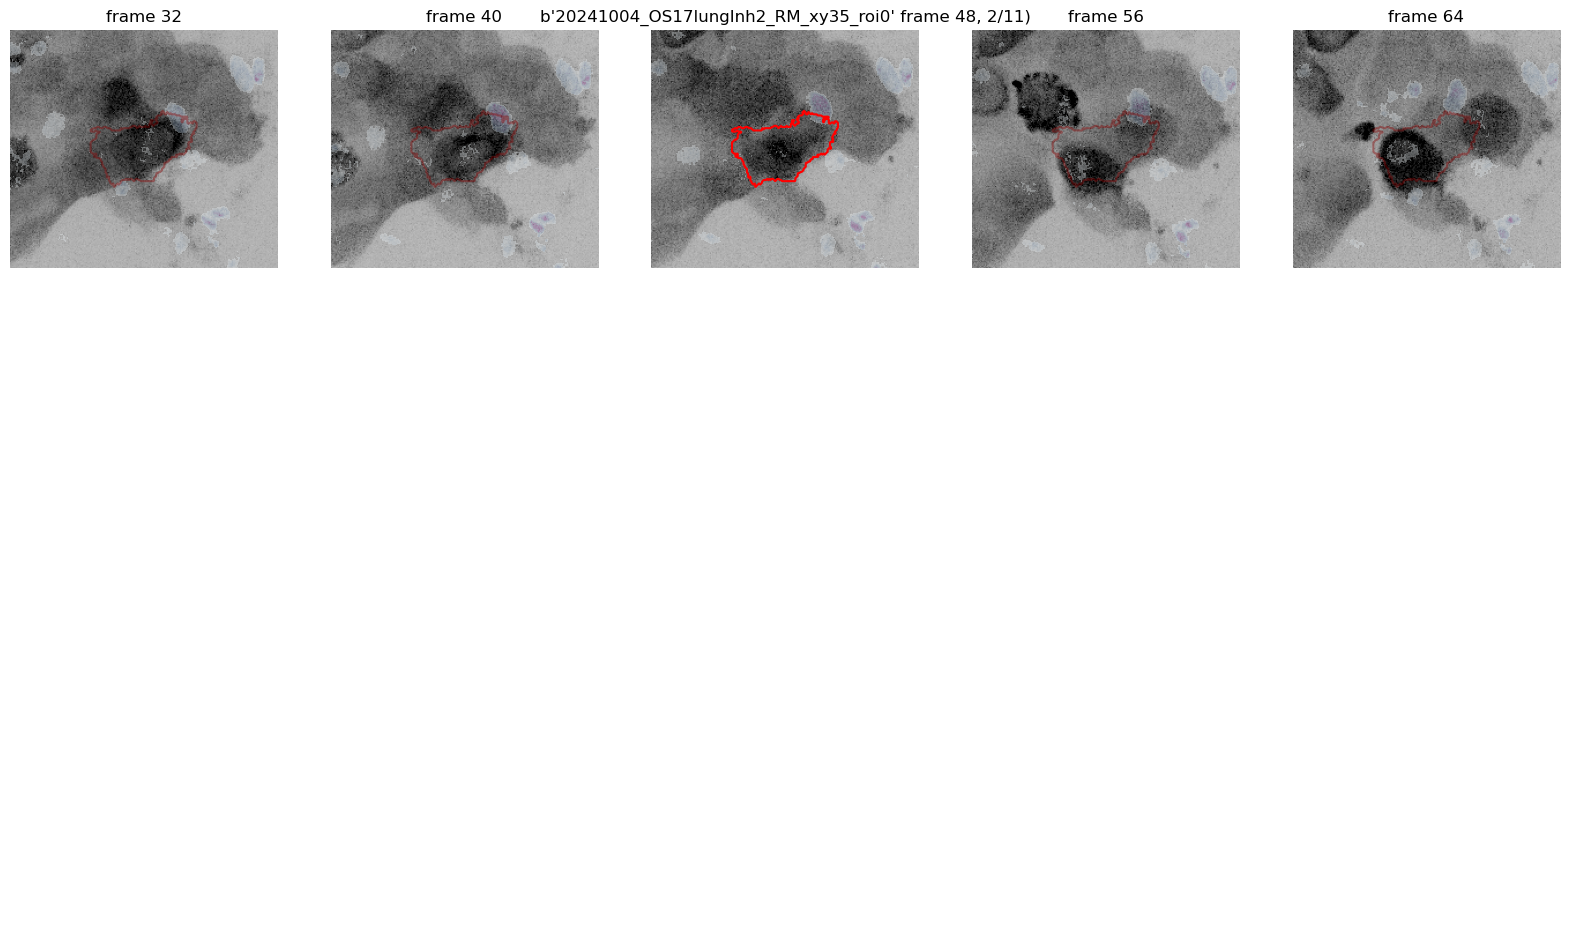

fate validation (q to quit, -1 can't tell, 0 not fate, 1 is fate):
 q


saving attributes ['inds_death', 'vals_death', 'indreviewed_death'] to /cell_data_m0/ in /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy35_roi0.h5
overwrote existing and saved inds_death to /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy35_roi0.h5//cell_data_m0/
overwrote existing and saved vals_death to /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy35_roi0.h5//cell_data_m0/
overwrote existing and saved indreviewed_death to /home/groups/CEDAR/copperma/dyn-cell-sys/makkawi/20241004_OS17lungInh2_RM/20241004_OS17lungInh2_RM_xy35_roi0.h5//cell_data_m0/


In [489]:
#review deaths again for a model
imodel=1
inds_death=inds_death_set[imodel]
sctm_fate=modelSet[imodel]
deathval_dir=f'./{date}/death_test_m{imodel}/'
os.system(f'mkdir {deathval_dir}')
inds_test,vals_test=sctm_fate.manual_fate_validation(inds_death,'death',show_allcells=False,show_linked=False,val_tracks=False,restart=False,trajl_past=2,trajl_future=2,stride=8,rep_channel=erk_img_channel,bf_channel=erk_img_channel,nuc_channel=nuc_img_channel,projection=True,msk_channel=cyto_msk_channel,pathto=deathval_dir,save_pic=True,boundary_expansion=[2,70,70],nuclow=90,save_h5=False,overwrite=False)

### randomly review segmentation and tracking to determine performance

In [490]:
trajl_future=0
trajl_past=1
fu=np.max(sctm.cells_frameSet-trajl_future)
fl=trajl_past
min_traj_len=1
min_size=sctm.cellpose_diam*sctm.cellpose_diam
#i_tm=np.where(np.array(tmSet)=='ctrl')[0][0]
#indmodels=np.where(inds_tmSet_models==i_tm)[0]
indmodels=indgood_models.copy()
indmodels=np.intersect1d(indmodels,indgood_models)
vals_seg_set=[None]*indmodels.size
inds_seg_set=[None]*indmodels.size
vals_track_set=[None]*indmodels.size
n_val=20
for iimodel in range(indmodels.size):
    imodel=indmodels[iimodel]
    sctm_fate=modelSet[imodel]
    indstw=np.where(np.logical_and(sctm.cells_frameSet<fu,sctm.cells_frameSet>fl))[0]
    inds_random = np.random.choice(indstw.size, n_val, replace=False)
    inds_test=indstw[inds_random]
    trackval_dir=f'./{date}/track_val_m{imodel}/'
    os.system(f'mkdir {trackval_dir}')
    print(f'validating {n_val} segs and tracks for {sctm.figid}, writing results to {trackval_dir}')
    vals_seg_set[iimodel],inds_seg_set[iimodel],vals_track_set[iimodel]=sctm_fate.manual_fate_validation(inds_track,'seg',restart=False,val_tracks=True,trajl_past=trajl_past,trajl_future=trajl_future,rep_channel=erk_img_channel,bf_channel=erk_img_channel,nuc_channel=nuc_img_channel,projection=False,msk_channel=cyto_msk_channel,pathto=trackval_dir,save_pic=True,boundary_expansion=[2,70,70],nuclow=90,save_h5=False,overwrite=False)

[ 257 2143 1260 2059 2315 2061 1631  303  207  280 3588 2381 2566 1523
 1196 2103 2198 2924  575 3585 2625 2346  529 3286 3315  621 1984 2199
 1860 2852 1863 1121  706  315 1871  190  132 1320 3136  222  366 1940
 2521  179 1970 1180 1556 1932  708 1105 2244  834  306  267  262 1186
 1768  494 1306  949 1097 1303  136  430 3449 2871 1304 3277 3362 3485
 2012 1979 2491 1972 2757 1913 1678  364  363  540 1555 2651 1602 1103
 2585  606 2523  687]
[ 5 51 29 49 55 49 38  6  4  6 94 57 63 36 28 50 52 73 12 94 65 56 11 84
 85 13 47 52 44 71 44 26 15  6 44  4  2 31 79  4  7 46 61  3 46 27 36 45
 15 25 53 18  6  5  5 28 41 10 30 21 25 30  2  9 89 71 30 84 86 91 47 47
 60 46 68 45 39  7  7 11 36 65 38 25 63 13 61 15]


mkdir: cannot create directory ‘./21nov24/track_val_m1/’: File exists


IndexError: index -2 is out of bounds for axis 0 with size 1

### validate divisions

[81, 82]


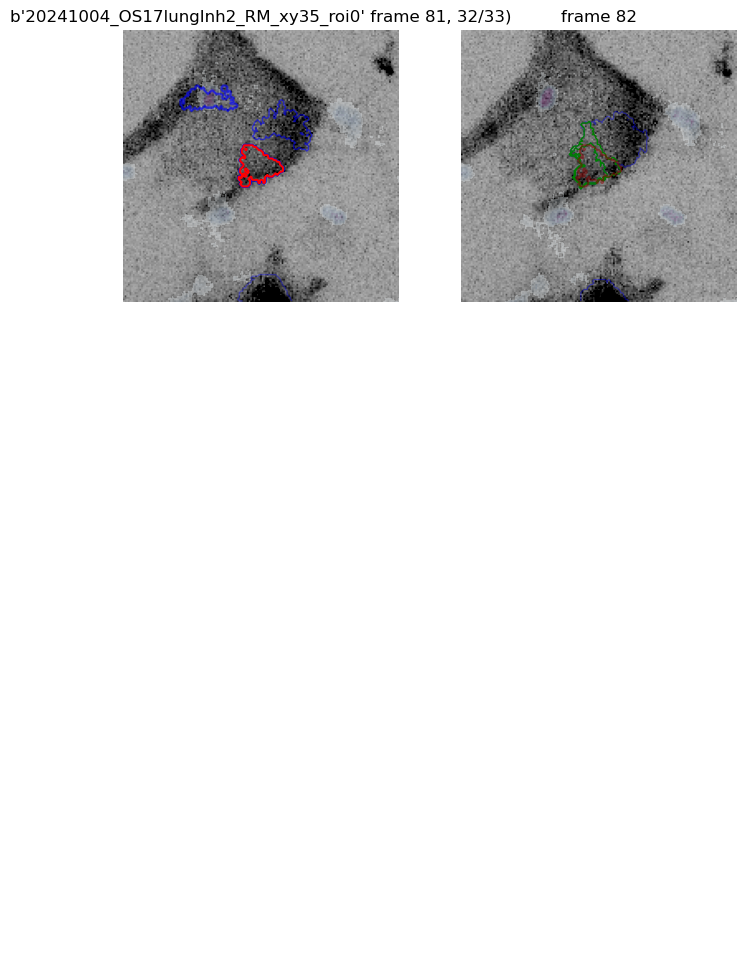

track validation (1 all good, -2 to break past link, 2 to break future link, 0 to break both):
 1
fate validation (q to quit, -1 can't tell, 0 not fate, 1 is fate):
 1


In [349]:
trajl_future=1
trajl_past=0
fu=np.max(sctm.cells_frameSet-trajl_future)
fl=trajl_past
min_traj_len=1
#i_tm=np.where(np.array(tmSet)=='ctrl')[0][0]
#indmodels=np.where(inds_tmSet_models==i_tm)[0]
indmodels=indgood_models.copy()
indmodels=np.intersect1d(indmodels,indgood_models)
vals_div_set=[None]*indmodels.size
inds_div_set=[None]*indmodels.size
vals_div_track_set=[None]*indmodels.size
for iimodel in [1]: #range(indmodels.size):
    imodel=indmodels[iimodel]
    sctm_fate=modelSet[imodel]
    cells_nchildren=sctm_fate.get_cells_nchildren()
    inds_div=np.where(cells_nchildren>1)[0]
    indstw=np.where(np.logical_and(sctm_fate.cells_frameSet[inds_div]<fu,sctm_fate.cells_frameSet[inds_div]>fl))[0]
    inds_div=inds_div[indstw]
    print(inds_div)
    print(sctm_fate.cells_frameSet[inds_div])
    div_val_dir=f'./{date}/div_val_m{imodel}/'
    os.system(f'mkdir {div_val_dir}')
    vals_div_set[iimodel],inds_div_set[iimodel],vals_div_track_set[iimodel]=sctm_fate.manual_fate_validation(inds_div,'div',restart=False,val_tracks=True,trajl_past=trajl_past,trajl_future=trajl_future,rep_channel=erk_img_channel,bf_channel=erk_img_channel,nuc_channel=nuc_img_channel,projection=True,msk_channel=cyto_msk_channel,pathto=div_val_dir,save_pic=True,boundary_expansion=[2,70,70],nuclow=90,save_h5=False,overwrite=False)

### death / persistors analysis

In [382]:
indmodels_death=np.array([1,2,3])

In [383]:
#signaling features
cratio_erk=np.array([]).astype(float)
for i in indmodels_death:
    sctm=modelSet[i]
    attr_str=f'img{erk_img_channel}_m{sctm.mskchannel}m{nuc_fmsk_channel}_ratio'
    cc=getattr(sctm,attr_str)
    cratio_erk=np.append(cratio_erk,cc)
    modelSet[i].x_signal=cc.copy()

cratio_erk_std=np.std(cratio_erk);cratio_erk_mean=np.mean(cratio_erk);#cratio_erk=imprep.znorm(cratio_erk)

In [384]:
#signaling features
cratio_akt=np.array([]).astype(float)
for i in indmodels_death:
    sctm=modelSet[i]
    attr_str=f'img{akt_img_channel}_m{sctm.mskchannel}m{nuc_fmsk_channel}_ratio'
    cc=getattr(sctm,attr_str)
    cratio_akt=np.append(cratio_akt,cc)
    modelSet[i].x_signal_akt=cc.copy()

cratio_akt_std=np.std(cratio_akt);cratio_akt_mean=np.mean(cratio_akt);#cratio_erk=imprep.znorm(cratio_erk)

cell death at frame 93 traced for 42 frames
cell death at frame 78 traced for 14 frames
cell death at frame 48 traced for 14 frames
cell death at frame 44 traced for 9 frames
cell death at frame 44 traced for 38 frames
cell death at frame 38 traced for 10 frames
cell death at frame 29 traced for 10 frames
cell death at frame 28 traced for 17 frames
cell death at frame 23 traced for 9 frames
cell death at frame 22 traced for 10 frames
cell death at frame 18 traced for 9 frames
cell death at frame 85 traced for 17 frames
cell death at frame 77 traced for 6 frames
cell death at frame 77 traced for 11 frames
cell death at frame 71 traced for 7 frames
cell death at frame 69 traced for 12 frames
cell death at frame 66 traced for 18 frames
cell death at frame 66 traced for 8 frames
cell death at frame 60 traced for 9 frames
cell death at frame 57 traced for 10 frames
cell death at frame 56 traced for 8 frames
cell death at frame 48 traced for 49 frames
cell death at frame 48 traced for 38 fra

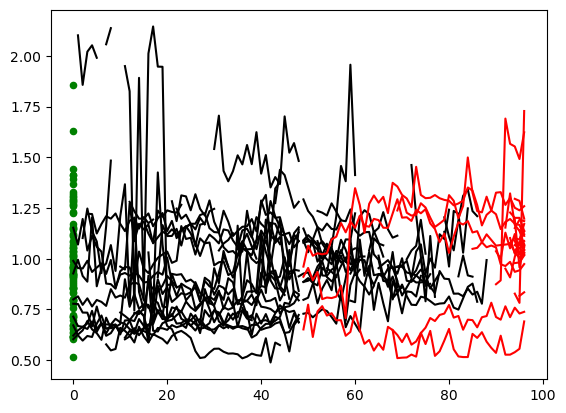

In [446]:
erk_trajs_death=[]
for imodel in indmodels_death:
    sctm=modelSet[imodel]
    for ideath in range(sctm.inds_death.size):
        ic=sctm.inds_death[ideath]
        cell_traj=sctm.get_cell_trajectory(ic)
        print(f'cell death at frame {sctm.cells_frameSet[ic]} traced for {cell_traj.size} frames')
        frames=sctm.cells_frameSet[cell_traj]
        erk_traj=sctm.x_signal[cell_traj]
        xtraj=np.ones(sctm.nt)*np.nan
        xtraj[frames]=erk_traj
        erk_trajs_death.append(xtraj)
        plt.plot(frames,erk_traj,color='black')

erk_trajs_persist=[]
for imodel in indmodels_death:
    sctm=modelSet[imodel]
    inds_persistors=np.where(sctm.cells_frameSet==np.max(sctm.cells_frameSet))[0]
    for ipersist in range(inds_persistors.size):
        ic=inds_persistors[ipersist]
        cell_traj=sctm.get_cell_trajectory(ic)
        print(f'cell death at frame {sctm.cells_frameSet[ic]} traced for {cell_traj.size} frames')
        frames=sctm.cells_frameSet[cell_traj]
        erk_traj=sctm.x_signal[cell_traj]
        xtraj=np.ones(sctm.nt)*np.nan
        xtraj[frames]=erk_traj
        erk_trajs_persist.append(xtraj)
        plt.plot(frames,erk_traj,color='red')

erk_initial=np.array([])
for imodel in indmodels_death:
    sctm=modelSet[imodel]
    inds_initial=np.where(sctm.cells_frameSet==0)[0]
    erk_initial=np.append(erk_initial,sctm.x_signal[inds_initial])

erk_initial=np.array(erk_initial)
plt.scatter(np.zeros_like(erk_initial),erk_initial,s=20,c='green',marker='o')

erk_trajs_persist=np.array(erk_trajs_persist)
erk_trajs_death=np.array(erk_trajs_death)
erk_trajs_initial=np.array(erk_trajs_initial)

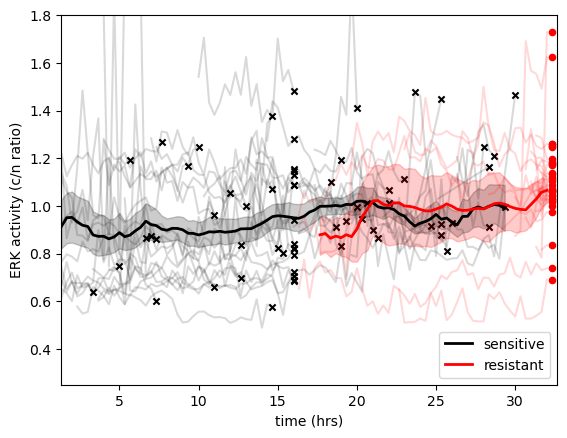

In [450]:
sys.path.append('/home/groups/ZuckermanLab/copperma/msmWE/BayesianBootstrap')
import bootstrap
import bootstrapN
scipy.average=np.mean
scipy.percentile=np.percentile
plt.figure()
ax=plt.gca()
fw=4
nframes=sctm.nt
timestep=.3333
x_means_death=np.ones(nframes)*np.nan
x_bounds_death=np.ones((nframes,2))*np.nan
for iframe in range(fw,nframes):
    fwindow=np.arange(iframe-fw,iframe).astype(int)
    xs=erk_trajs_death[:,fwindow].flatten()
    xs=xs[np.isfinite(xs)]
    if xs.size>10:
        x_bounds_death[iframe,:]=bootstrap.get_CI(xs,1000)
        x_means_death[iframe]=np.nanmean(xs)

for itraj in range(len(erk_trajs_death)):
    frames=np.where(np.isfinite(erk_trajs_death[itraj,:]))[0]
    if frames.size>0:
        ax.plot(frames*timestep,erk_trajs_death[itraj,frames],'-',color='black',alpha=.15)
        ax.scatter([frames[-1]*timestep],[erk_trajs_death[itraj,frames[-1]]],s=20,c='black',marker='x')

ax.plot(np.arange(nframes)*timestep,x_means_death,'-',color='black',linewidth=2,label='sensitive')
ax.fill_between(np.arange(nframes)*timestep,x_bounds_death[:,0],x_bounds_death[:,1],color='black',alpha=.2)

x_means_persist=np.ones(nframes)*np.nan
x_bounds_persist=np.ones((nframes,2))*np.nan
for iframe in range(fw,nframes):
    fwindow=np.arange(iframe-fw,iframe).astype(int)
    xs=erk_trajs_persist[:,fwindow].flatten()
    xs=xs[np.isfinite(xs)]
    if xs.size>10:
        x_bounds_persist[iframe,:]=bootstrap.get_CI(xs,1000)
        x_means_persist[iframe]=np.nanmean(xs)

for itraj in range(len(erk_trajs_persist)):
    ax.plot(np.where(np.isfinite(erk_trajs_persist[itraj,:]))[0]*timestep,erk_trajs_persist[itraj,np.where(np.isfinite(erk_trajs_persist[itraj,:]))[0]],'-',color='red',alpha=.15)
    ax.scatter([nframes*timestep],[erk_trajs_persist[itraj,-1]],s=20,c='red',marker='o')
    
ax.plot(np.arange(nframes)*timestep,x_means_persist,'-',color='red',linewidth=2,label='resistant')
ax.fill_between(np.arange(nframes)*timestep,x_bounds_persist[:,0],x_bounds_persist[:,1],color='red',alpha=.2)

#plt.scatter(np.ones_like(erk_initial),erk_initial,s=20,c='green',marker='o')

plt.ylabel('ERK activity (c/n ratio)')
plt.xlabel('time (hrs)')
plt.ylim(.25,1.8)
plt.xlim(fw*timestep,(nframes+1)*timestep)
plt.legend(loc='lower right') #(bbox_to_anchor=(1.1, 1.0))
plt.savefig(f'{date}/erk_activity_dead_alive.png')

In [507]:
frames_death=[]
erk_death=[]
akt_death=[]
lungf_death=[]
cc_death=[]
for imodel in indmodels_death:
    sctm=modelSet[imodel]
    for ideath in range(sctm.inds_death.size):
        ic=sctm.inds_death[ideath]
        frames_death.append(sctm.cells_frameSet[ic])
        erk_death.append(sctm.x_signal[ic])
        akt_death.append(sctm.x_signal_akt[ic])
        indboundary=np.where(sctm.boundary_library['global_index']==ic)[0]
        rdx_cc=np.linalg.norm(sctm.boundary_library['nn_pts_states'][indboundary,1,:]-sctm.boundary_library['pts'][indboundary,:],axis=1)
        rdx_lung=np.linalg.norm(sctm.boundary_library['nn_pts_states'][indboundary,3,:]-sctm.boundary_library['pts'][indboundary,:],axis=1)
        lungf_death.append(np.nanmean(rdx_lung))
        cc_death.append(np.nanmean(rdx_cc))
        
frames_persist=[]
erk_persist=[]
akt_persist=[]
lungf_persist=[]
cc_persist=[]
for imodel in indmodels_death:
    sctm=modelSet[imodel]
    inds_persistors=np.where(sctm.cells_frameSet==np.max(sctm.cells_frameSet))[0]
    for ipersist in range(inds_persistors.size):
        ic=inds_persistors[ipersist]
        frames_persist.append(sctm.cells_frameSet[ic])
        erk_persist.append(sctm.x_signal[ic])
        akt_persist.append(sctm.x_signal_akt[ic])
        indboundary=np.where(sctm.boundary_library['global_index']==ic)[0]
        rdx_cc=np.linalg.norm(sctm.boundary_library['nn_pts_states'][indboundary,1,:]-sctm.boundary_library['pts'][indboundary,:],axis=1)
        rdx_lung=np.linalg.norm(sctm.boundary_library['nn_pts_states'][indboundary,3,:]-sctm.boundary_library['pts'][indboundary,:],axis=1)
        lungf_persist.append(np.nanmean(rdx_lung))
        cc_persist.append(np.nanmean(rdx_cc))

frames_initial=[]
erk_initial=[]
akt_initial=[]
lungf_initial=[]
cc_initial=[]
for imodel in indmodels_death:
    sctm=modelSet[imodel]
    inds_initial=np.where(sctm.cells_frameSet==0)[0]
    for icell in range(inds_initial.size):
        ic=inds_initial[icell]
        frames_initial.append(sctm.cells_frameSet[ic])
        erk_initial.append(sctm.x_signal[ic])
        akt_initial.append(sctm.x_signal_akt[ic])
        indboundary=np.where(sctm.boundary_library['global_index']==ic)[0]
        rdx_cc=np.linalg.norm(sctm.boundary_library['nn_pts_states'][indboundary,1,:]-sctm.boundary_library['pts'][indboundary,:],axis=1)
        rdx_lung=np.linalg.norm(sctm.boundary_library['nn_pts_states'][indboundary,3,:]-sctm.boundary_library['pts'][indboundary,:],axis=1)
        lungf_initial.append(np.nanmean(rdx_lung))
        cc_initial.append(np.nanmean(rdx_cc))

/tmp/ipykernel_6845/206265988.py:16: RuntimeWarning: Mean of empty slice
  lungf_death.append(np.nanmean(rdx_lung))
/tmp/ipykernel_6845/206265988.py:35: RuntimeWarning: Mean of empty slice
  lungf_persist.append(np.nanmean(rdx_lung))
/tmp/ipykernel_6845/206265988.py:36: RuntimeWarning: Mean of empty slice
  cc_persist.append(np.nanmean(rdx_cc))


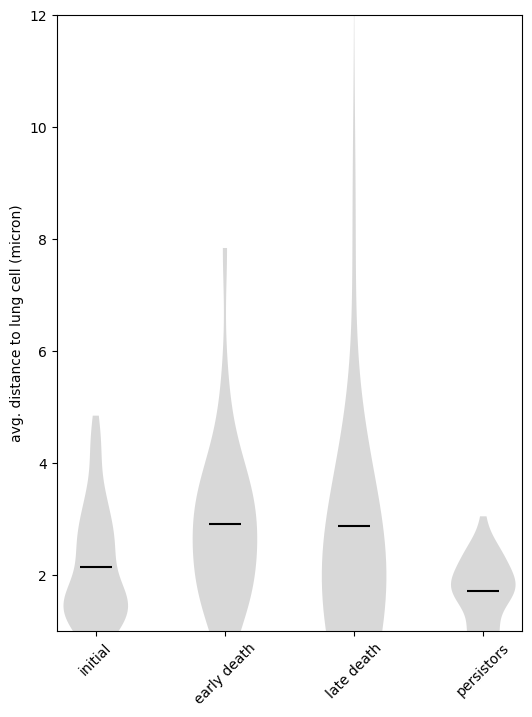

In [538]:
framecut_early=50
fig=plt.figure(figsize=(6,8))
ax=plt.gca()
setv=np.array(lungf_initial)/sctm.boundary_library['border_resolution']
vplot=ax.violinplot(setv[np.isfinite(setv)],positions=[0],showmeans=True,showextrema=False) #,quantiles=[.05,.95])
vplot['cmeans'].set_color('black')
for pc in vplot['bodies']:
    pc.set_facecolor('gray')

inds_early=np.where(np.array(frames_death)<framecut_early)[0]
setv=np.array(lungf_death)[inds_early]/sctm.boundary_library['border_resolution']
vplot=ax.violinplot(setv[np.isfinite(setv)],positions=[1],showmeans=True,showextrema=False) #,quantiles=[.05,.95])
vplot['cmeans'].set_color('black')
for pc in vplot['bodies']:
    pc.set_facecolor('gray')

inds_late=np.where(np.array(frames_death)>=framecut_early)[0]
setv=np.array(lungf_death)[inds_late]/sctm.boundary_library['border_resolution']
vplot=ax.violinplot(setv[np.isfinite(setv)],positions=[2],showmeans=True,showextrema=False) #,quantiles=[.05,.95])
vplot['cmeans'].set_color('black')
for pc in vplot['bodies']:
    pc.set_facecolor('gray')

setv=np.array(lungf_persist)/sctm.boundary_library['border_resolution']
vplot=ax.violinplot(setv[np.isfinite(setv)],positions=[3],showmeans=True,showextrema=False) #,quantiles=[.05,.95])
vplot['cmeans'].set_color('black')
for pc in vplot['bodies']:
    pc.set_facecolor('gray')

ax.set_xlim(-.3,3.3)
ax.set_ylim(1,12)
ax.set_xticks(range(0,3+1))
ax.set_xticklabels(['initial','early death','late death','persistors'],rotation=45)
ax.set_ylabel('avg. distance to lung cell (micron)')
plt.savefig(f'{date}/lung_contact_earlylate.png')

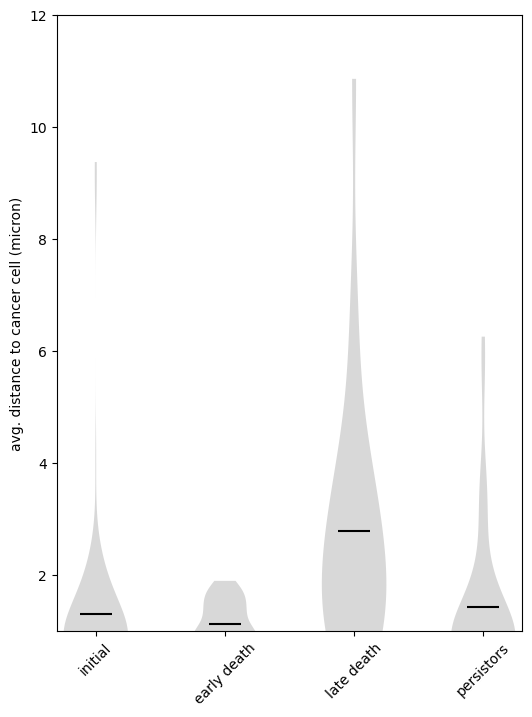

In [539]:
framecut_early=50
fig=plt.figure(figsize=(6,8))
ax=plt.gca()
setv=np.array(cc_initial)/sctm.boundary_library['border_resolution']
vplot=ax.violinplot(setv[np.isfinite(setv)],positions=[0],showmeans=True,showextrema=False) #,quantiles=[.05,.95])
vplot['cmeans'].set_color('black')
for pc in vplot['bodies']:
    pc.set_facecolor('gray')

inds_early=np.where(np.array(frames_death)<framecut_early)[0]
setv=np.array(cc_death)[inds_early]/sctm.boundary_library['border_resolution']
vplot=ax.violinplot(setv[np.isfinite(setv)],positions=[1],showmeans=True,showextrema=False) #,quantiles=[.05,.95])
vplot['cmeans'].set_color('black')
for pc in vplot['bodies']:
    pc.set_facecolor('gray')

inds_late=np.where(np.array(frames_death)>=framecut_early)[0]
setv=np.array(cc_death)[inds_late]/sctm.boundary_library['border_resolution']
vplot=ax.violinplot(setv[np.isfinite(setv)],positions=[2],showmeans=True,showextrema=False) #,quantiles=[.05,.95])
vplot['cmeans'].set_color('black')
for pc in vplot['bodies']:
    pc.set_facecolor('gray')

setv=np.array(cc_persist)/sctm.boundary_library['border_resolution']
vplot=ax.violinplot(setv[np.isfinite(setv)],positions=[3],showmeans=True,showextrema=False) #,quantiles=[.05,.95])
vplot['cmeans'].set_color('black')
for pc in vplot['bodies']:
    pc.set_facecolor('gray')

ax.set_xlim(-.3,3.3)
ax.set_ylim(1,12)
ax.set_xticks(range(0,3+1))
ax.set_xticklabels(['initial','early death','late death','persistors'],rotation=45)
ax.set_ylabel('avg. distance to cancer cell (micron)')
plt.savefig(f'{date}/cancer_contact_earlylate.png')

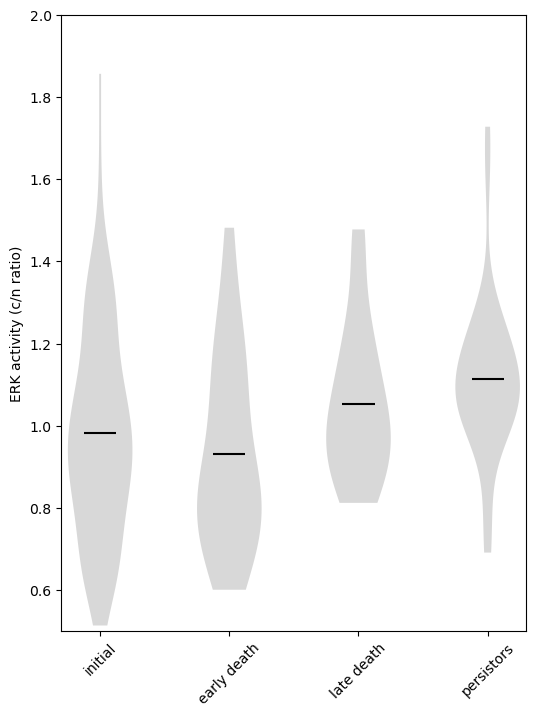

In [540]:
framecut_early=50
fig=plt.figure(figsize=(6,8))
ax=plt.gca()
setv=np.array(erk_initial)
vplot=ax.violinplot(setv[np.isfinite(setv)],positions=[0],showmeans=True,showextrema=False) #,quantiles=[.05,.95])
vplot['cmeans'].set_color('black')
for pc in vplot['bodies']:
    pc.set_facecolor('gray')

inds_early=np.where(np.array(frames_death)<framecut_early)[0]
setv=np.array(erk_death)[inds_early]
vplot=ax.violinplot(setv[np.isfinite(setv)],positions=[1],showmeans=True,showextrema=False) #,quantiles=[.05,.95])
vplot['cmeans'].set_color('black')
for pc in vplot['bodies']:
    pc.set_facecolor('gray')

inds_late=np.where(np.array(frames_death)>=framecut_early)[0]
setv=np.array(erk_death)[inds_late]
vplot=ax.violinplot(setv[np.isfinite(setv)],positions=[2],showmeans=True,showextrema=False) #,quantiles=[.05,.95])
vplot['cmeans'].set_color('black')
for pc in vplot['bodies']:
    pc.set_facecolor('gray')

setv=np.array(erk_persist)
vplot=ax.violinplot(setv[np.isfinite(setv)],positions=[3],showmeans=True,showextrema=False) #,quantiles=[.05,.95])
vplot['cmeans'].set_color('black')
for pc in vplot['bodies']:
    pc.set_facecolor('gray')

ax.set_xlim(-.3,3.3)
ax.set_ylim(.5,2)
ax.set_xticks(range(0,3+1))
ax.set_xticklabels(['initial','early death','late death','persistors'],rotation=45)
ax.set_ylabel('ERK activity (c/n ratio)')
plt.savefig(f'{date}/erk_activity_earlylate.png')

cell death at frame 93 traced for 42 frames
cell death at frame 78 traced for 14 frames
cell death at frame 48 traced for 14 frames
cell death at frame 44 traced for 9 frames
cell death at frame 44 traced for 38 frames
cell death at frame 38 traced for 10 frames
cell death at frame 29 traced for 10 frames
cell death at frame 28 traced for 17 frames
cell death at frame 23 traced for 9 frames
cell death at frame 22 traced for 10 frames
cell death at frame 18 traced for 9 frames
cell death at frame 85 traced for 17 frames
cell death at frame 77 traced for 6 frames
cell death at frame 77 traced for 11 frames
cell death at frame 71 traced for 7 frames
cell death at frame 69 traced for 12 frames
cell death at frame 66 traced for 18 frames
cell death at frame 66 traced for 8 frames
cell death at frame 60 traced for 9 frames
cell death at frame 57 traced for 10 frames
cell death at frame 56 traced for 8 frames
cell death at frame 48 traced for 49 frames
cell death at frame 48 traced for 38 fra

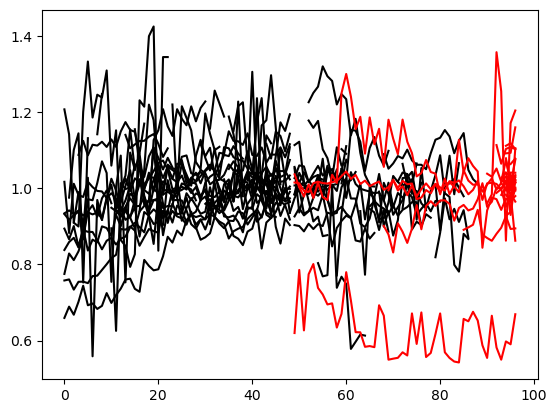

In [391]:
for imodel in indmodels_death:
    sctm=modelSet[imodel]
    for ideath in range(sctm.inds_death.size):
        ic=sctm.inds_death[ideath]
        cell_traj=sctm.get_cell_trajectory(ic)
        print(f'cell death at frame {sctm.cells_frameSet[ic]} traced for {cell_traj.size} frames')
        frames=sctm.cells_frameSet[cell_traj]
        akt_traj=sctm.x_signal_akt[cell_traj]
        plt.plot(frames,akt_traj,color='black')

for imodel in indmodels_death:
    sctm=modelSet[imodel]
    inds_persistors=np.where(sctm.cells_frameSet==np.max(sctm.cells_frameSet))[0]
    for ipersist in range(inds_persistors.size):
        ic=inds_persistors[ipersist]
        cell_traj=sctm.get_cell_trajectory(ic)
        print(f'cell death at frame {sctm.cells_frameSet[ic]} traced for {cell_traj.size} frames')
        frames=sctm.cells_frameSet[cell_traj]
        akt_traj=sctm.x_signal_akt[cell_traj]
        plt.plot(frames,akt_traj,color='red')